In [35]:
import numpy as np
import pickle
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AutoTokenizer, AutoModel, AutoConfig
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
from tqdm import tqdm
import circuitsvis as cv
from torch.utils.data import DataLoader, Dataset


from jaxtyping import Float
from functools import partial
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature
from modular_transformers.models import components


from datasets import load_dataset, load_from_disk
import os

# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix

from matplotlib import pyplot as plt

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
path = "/om2/user/jackking/modular_transformers/scripts/attention_interpretability"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_grad_enabled(False)

from scipy.stats import pearsonr

In [1]:
import os
import torch
from transformers import GPT2LMHeadModel, AutoTokenizer
from tqdm.auto import tqdm
import math
from pathlib import Path
import math

from modular_transformers.models.gpt2.configuration_gpt2 import GPT2Config
from modular_transformers.models import components
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature

from transformer_xray.perturb_utils import *

import matplotlib.pyplot as plt
import random
import numpy as np

from datasets import load_dataset, load_from_disk
from torch.utils.data import DataLoader, Dataset

import pickle

from scikitplot.decomposition import plot_pca_2d_projection, plot_pca_component_variance
from sklearn.decomposition import PCA

/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Curvature Attribution using Gradients

In [2]:
class LMDataset(Dataset):
    def __init__(self, inputs, attn_mask=None, labels=None):
        #cast to tensors if not already tensors
        if not torch.is_tensor(inputs):
            inputs = torch.tensor(inputs)
        if not torch.is_tensor(labels):
            labels = torch.tensor(labels)
        if attn_mask is not None and not torch.is_tensor(attn_mask):
            attn_mask = torch.tensor(attn_mask)
            
        self.inputs = inputs
        self.attn_mask = attn_mask
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if self.labels is None:
            item = {
                'input_ids': self.inputs[idx],
                'attention_mask': self.attn_mask[idx]}
        elif self.attn_mask is None:
            item = {
                'input_ids': self.inputs[idx],
                'labels': self.labels[idx]
            }
        else:
            item = {
                'input_ids': self.inputs[idx],
                'attention_mask': self.attn_mask[idx],
                'labels': self.labels[idx]
            }
        return item

In [4]:
path = "/om2/user/jackking/modular_transformers/scripts/dimensionality_reduction"
datatype = "natural_language"
data = pickle.load(open(f"{path}/data/{datatype}/train_data_natural.pkl", 'rb'))[:5000]

batch_size = 32

ctx_len = len(data[0])
trainset = LMDataset(data, labels=data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

tokenizer = AutoTokenizer.from_pretrained("gpt2", fast=False)
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
state_dict = model.state_dict()

In [16]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", fast=False)
tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

straightest_layer = 33
embedding_dim = 1600
num_layers = 48
num_heads = 25

straightest_layer = 9
embedding_dim = 768
num_layers = 12
num_heads = 12

loss_hooks = {straightest_layer: "l2_curvature"}

config = {'regsize': embedding_dim, 'vocab_size': len(tokenizer), 'n_ctx': ctx_len, 'bos_token_id': tokenizer.bos_token_id,
                        'eos_token_id': tokenizer.eos_token_id, "bottleneck": embedding_dim, "n_layer": num_layers, "loss_hooks": loss_hooks, "n_heads": num_heads}
                        
config = GPT2Config(config)
model = components.LM(config)
model.load_state_dict(state_dict, strict=False)


<All keys matched successfully>

In [17]:
model.to(device)
model.set_hooks()
model.eval()

heads = {}

def retrieve_heads(layer):
    def hook(module, input, output):
        global curvature
        output = output[1][0]
        output.retain_grad()
        heads[layer] = output
    return hook

for layer in range(straightest_layer):
    model.transformer.h[layer].register_forward_hook(retrieve_heads(layer))

curvature_losses = []
l2_losses = []
logit_losses = []
starting_logit_loss = 0
final_gradients = np.zeros((straightest_layer, num_heads))

for i, batch in enumerate(tqdm(trainloader)):
    outputs = model.forward_with_extra_loss(batch["input_ids"].to(device))

    losses = model.output_extra_losses()
    curvature_loss = 0
    for loss in losses.values():
        if loss is not None:
            curvature_loss += loss
    curvature_loss = -curvature_loss #looking for gradients that most decrease the curvature
    
    curvature_loss.backward()

    for layer in range(straightest_layer):
        gradients = heads[layer].grad.cpu().detach().numpy()
        gradients = np.mean(gradients, axis=(0, 2, 3))
        final_gradients[layer] += gradients

    model.zero_grad()
    torch.cuda.empty_cache()


100%|██████████| 157/157 [00:34<00:00,  4.57it/s]


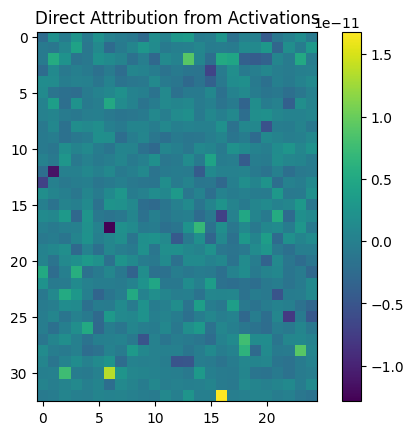

In [13]:
xl_gradients = final_gradients
plt.imshow(xl_gradients, cmap='viridis')
plt.colorbar()
plt.title(f'Direct Attribution from Activations')
plt.show()

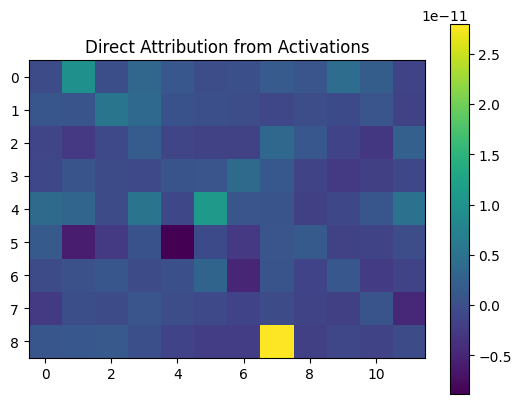

In [18]:
plt.imshow(final_gradients, cmap='viridis')
plt.colorbar()
plt.title(f'Direct Attribution from Activations')
plt.show()

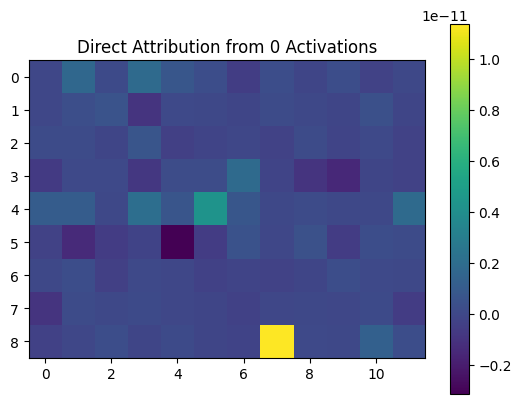

In [44]:
plt.imshow(final_gradients, cmap='viridis')
plt.colorbar()
plt.title(f'Direct Attribution from Activations')
plt.show()

# Collecting Attention Patterns

In [3]:
def collect_patterns(sentences, model_name):
    if model_name == "gpt2":
        hooked_model_name = "gpt2-small"
    else:
        hooked_model_name = model_name
    model = HookedTransformer.from_pretrained(hooked_model_name, device=device)
    config = AutoConfig.from_pretrained(model_name)
    sentences = sentences.to(device)
    gpt2_logits, gpt2_cache = model.run_with_cache(sentences)
    return gpt2_cache, config

def display_patterns(gpt2_cache, layer=1, heads=np.arange(12)):
    
    attention_pattern = gpt2_cache["pattern", layer, "attn"]

    avg_attention_pattern = attention_pattern.mean(dim=0).cpu().numpy()

    fig, ax = plt.subplots(1, len(heads), figsize=(20, 5))

    for i, head_idx in enumerate(heads):
        ax[i].imshow(avg_attention_pattern[head_idx], cmap="hot", interpolation="nearest")
        ax[i].set_title(f"Head {head_idx}")
        ax[i].grid(which="minor", color="black", linestyle="-", linewidth=1)
        ax[i].set_xlabel("To")
        ax[i].set_ylabel("From")

    plt.tight_layout()
    plt.show()

In [55]:
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)

In [63]:
two_word_samples = pickle.load(open(f"{path}/data/two_word_sets.pkl", "rb"))
two_word_samples = torch.tensor(two_word_samples)
batch_size = 200
two_word_samples = two_word_samples.view(-1, batch_size, 2)

100%|██████████| 500/500 [00:17<00:00, 29.07it/s]


I like
like New
The man


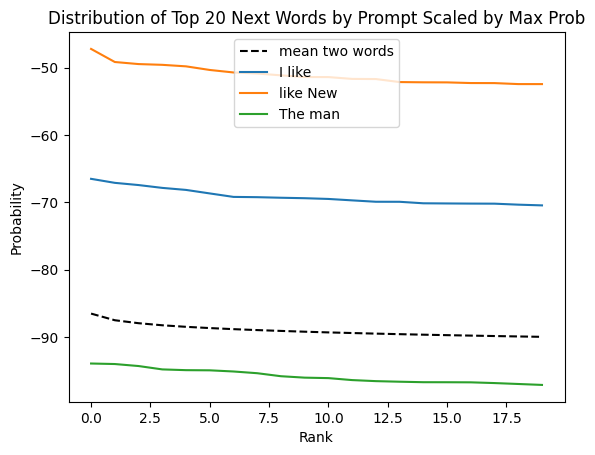

In [68]:
def get_probs(prompt):
    probs = model(torch.tensor(tokenizer.encode(prompt)).to(device)).logits[-1, :]
    # print(logits.shape)
    # probs = torch.nn.functional.softmax(probs, dim=0)
    #find the top 20 words
    words = torch.sort(probs).indices[-20:]
    words = tokenizer.decode(words)
    # print(words)
    probs = torch.sort(probs).values[-20:]
    return torch.flip(probs, dims=[0]).cpu().detach().numpy()

total_probs = []
batch_size = 128

for batch in tqdm(two_word_samples):

    probs = model(batch.to(device)).logits[:, -1, :]
    # print(logits.shape)
    # probs = torch.nn.functional.softmax(logits, dim=1)
    for prob in probs:
        prob = torch.sort(prob).values[-20:]
        total_probs.append(torch.flip(prob, dims=[0]).cpu().detach().numpy())

total_probs = np.array(total_probs)
total_probs = np.mean(total_probs, axis=0) #/ np.max(total_probs, axis=0)
plt.plot(total_probs, label="mean two words", color='black', linestyle='dashed')
# plt.plot(total_probs, label="mean two words")


prompts = ["I like", "like New", "The man"]
for prompt in prompts:
    print(prompt)
    probs = get_probs(prompt)
    probs = probs# / max(probs)
    plt.plot(probs, label=prompt)

#log y 
# plt.yscale('log')
plt.title("Distribution of Top 20 Next Words by Prompt Scaled by Max Prob")
plt.xlabel("Rank")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [37]:
probs.shape

torch.Size([4, 50257])

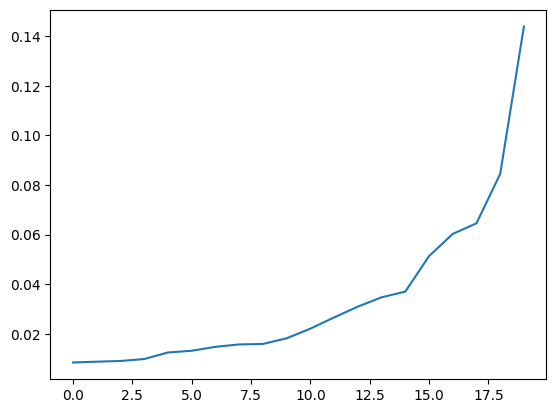

In [32]:
logits = model(torch.tensor(tokenizer.encode("I like "))).logits
probs = torch.nn.functional.softmax(logits, dim=-1)
#sort logits
sorted_probs = torch.sort(probs[-1, :]).values[-20:]
plt.plot(sorted_probs)

### Compare by curvature

In [7]:
model_name = "gpt2-xl"
data_source = "miniberta"

curvatures = pickle.load(open(f"{path}/data/{model_name}_{data_source}_curvatures.pkl", "rb"))
clean_sentences = pickle.load(open(f"{path}/data/{model_name}_{data_source}_clean_sentences.pkl", "rb"))

# #pick top x sentences with highest curvature and top x sentences with lowest curvature
# curvature = np.min(curvatures["curve"], axis=0)

# num_selected = 50

# top_50 = np.argsort(curvature)[-num_selected:]
# bottom_50 = np.argsort(curvature)[:num_selected]

# sentence_len = 10

# top_sentences = torch.tensor([clean_sentences[i][:sentence_len] for i in top_50])
# top_curvatures = torch.tensor([curvature[i] for i in top_50])
# bottom_sentences = torch.tensor([clean_sentences[i][:sentence_len] for i in bottom_50])
# bottom_curvatures = torch.tensor([curvature[i] for i in bottom_50])

# all_top_activations, model_config = collect_patterns(top_sentences, model_name)
# all_bottom_activations, _ = collect_patterns(bottom_sentences, model_name)

FileNotFoundError: [Errno 2] No such file or directory: '/om2/user/jackking/modular_transformers/scripts/attention_interpretability/data/gpt2-xl_miniberta_curvatures.pkl'

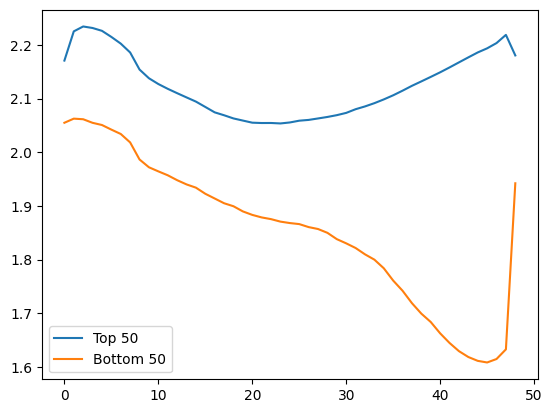

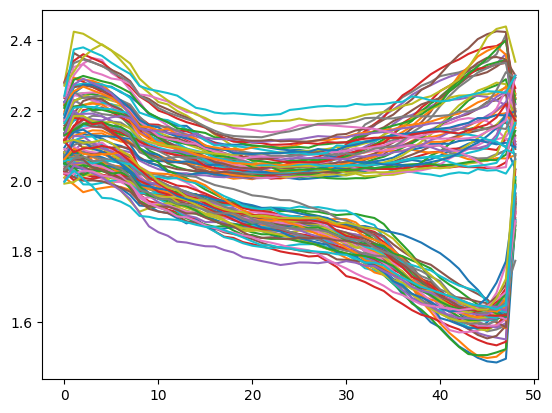

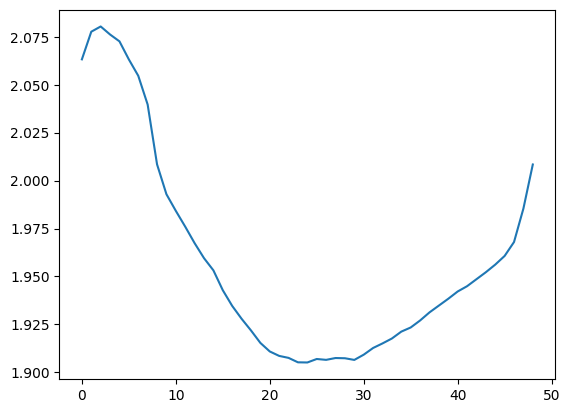

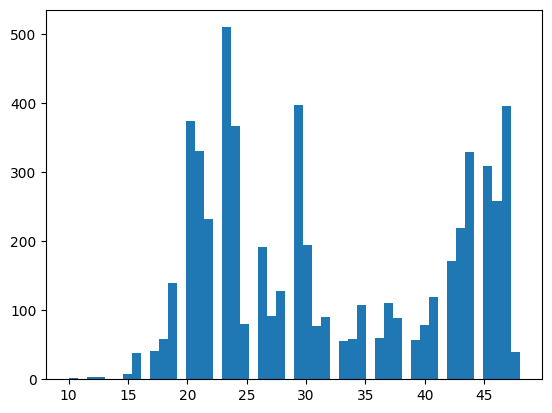

In [5]:
top_curvatures = curvatures["curve"][:, top_50]
bottom_curvatures = curvatures["curve"][:, bottom_50]

plt.plot(np.mean(top_curvatures, axis=1), label="Top 50")
plt.plot(np.mean(bottom_curvatures, axis=1), label="Bottom 50")
plt.legend()
plt.show()

plt.plot(top_curvatures)
plt.plot(bottom_curvatures)
plt.show()

plt.plot(np.mean(curvatures["curve"], axis=1))
plt.show()

plt.hist(np.argmin(curvatures["curve"], axis=0), bins=50)
plt.show()

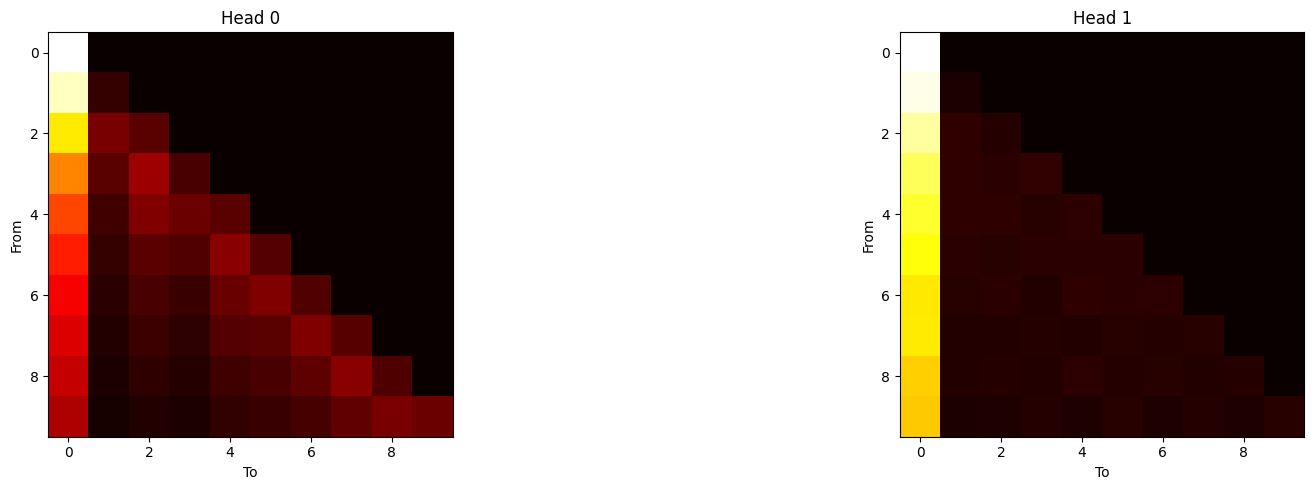

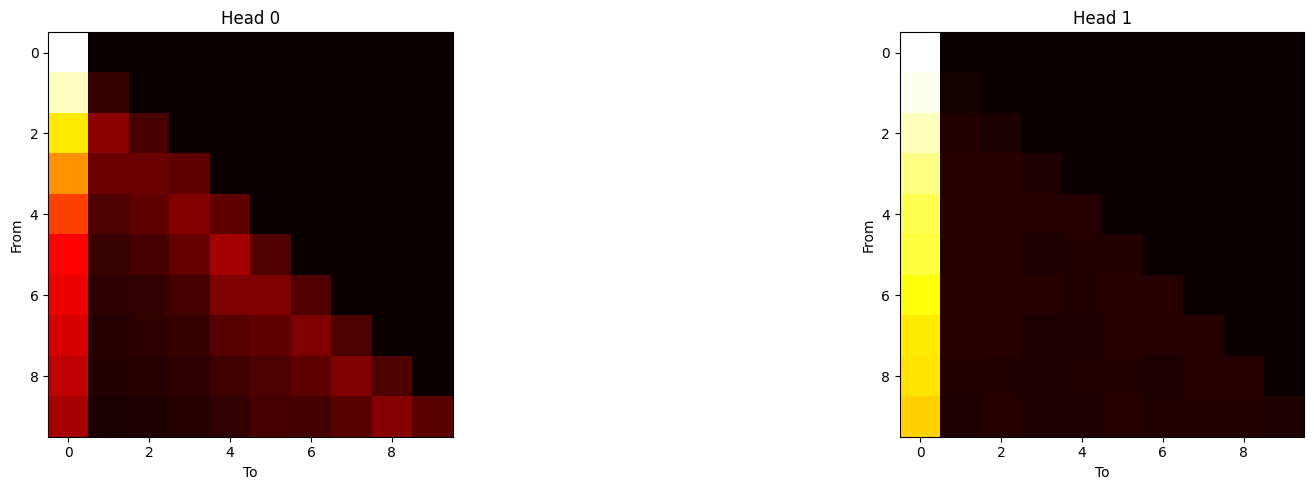

In [152]:
display_patterns(all_top_activations, layer=2, heads=[0, 1])
display_patterns(all_bottom_activations, layer=2, heads=[0, 1])

### Compare by sentence statistics

In [3]:
max_length = 10
fast_sentences = pickle.load(open(f"{path}/data/{max_length}word_fast_sentences.pkl", "rb"))
slow_sentences = pickle.load(open(f"{path}/data/{max_length}word_slow_sentences.pkl", "rb"))

fast_sentences = tokenizer(fast_sentences, return_tensors="pt", truncation=True)["input_ids"]
slow_sentences = tokenizer(slow_sentences, return_tensors="pt", truncation=True)["input_ids"]

model_name = "gpt2-xl"
fast_activations, model_config = collect_patterns(fast_sentences, model_name)
slow_activations, _ = collect_patterns(slow_sentences, model_name)

Loaded pretrained model gpt2-xl into HookedTransformer
Loaded pretrained model gpt2-xl into HookedTransformer


### Find most different patterns

In [41]:
def z_score_normalization(matrix):
    mean = np.mean(matrix)
    std = np.std(matrix)
    return (matrix - mean) / std

In [156]:
def compare_all_patterns(all_activations1, all_activations2, model_config):
    correlation_dict = {}
    kl_dict = {}

    for layer in range(model_config.n_layer):
        correlation_dict[layer] = {}
        kl_dict[layer] = {}
        for head in range(model_config.n_head):
            activations1 = all_activations1["pattern", layer, "attn"][head]
            activations2 = all_activations2["pattern", layer, "attn"][head]

            activations1 = activations1.mean(dim=0).cpu().numpy()
            activations2 = activations2.mean(dim=0).cpu().numpy()

            #get the bottom triangular matrix
            tril = np.tril_indices(activations1.shape[1])
            activations1 = activations1[tril]
            activations2 = activations2[tril]

            #normalize
            activations1 = z_score_normalization(activations1)
            activations2 = z_score_normalization(activations2)

            correlation = pearsonr(activations1, activations2)[0]
            kl_div = np.sum(activations1 * np.log(activations1 / activations2))

            correlation_dict[layer][head] = correlation
            kl_dict[layer][head] = kl_div

    #output lowest 5 correlations
    fig, axs = plt.subplots(model_config.n_layer//2, 2, figsize=(20, 50))
    #add vertical space
    fig.subplots_adjust(hspace=0.5)
    for layer, ax in zip(range(model_config.n_layer), axs.flatten()):
        sorted_correlations = sorted(correlation_dict[layer].items(), key=lambda x: x[1], reverse=False)
        for i in range(5):
            # print(f"Head {sorted_correlations[i][0]}: {sorted_correlations[i][1]}")
            ax.bar(sorted_correlations[i][0], sorted_correlations[i][1])
        ax.set_title(f"Layer {layer}")
        ax.set_ylim(0, 1)
        ax.set_xlim(0, model_config.n_head)

    plt.show()

    #output highest 5 KL divergences
    fig, axs = plt.subplots(model_config.n_layer//2, 2, figsize=(20, 50))
    #add vertical space
    fig.subplots_adjust(hspace=0.5)
    for layer, ax in zip(range(model_config.n_layer), axs.flatten()):
        sorted_kls = sorted(kl_dict[layer].items(), key=lambda x: x[1], reverse=True)
        for i in range(5):
            # print(f"Head {sorted_kls[i][0]}: {sorted_kls[i][1]}")
            ax.bar(sorted_kls[i][0], sorted_kls[i][1])
        ax.set_title(f"Layer {layer}")
        ax.set_ylim(0, 1)
        ax.set_xlim(0, model_config.n_head)

    plt.show()

/tmp/ipykernel_3238881/1134085080.py:25: RuntimeWarning: invalid value encountered in log
  kl_div = np.sum(activations1 * np.log(activations1 / activations2))


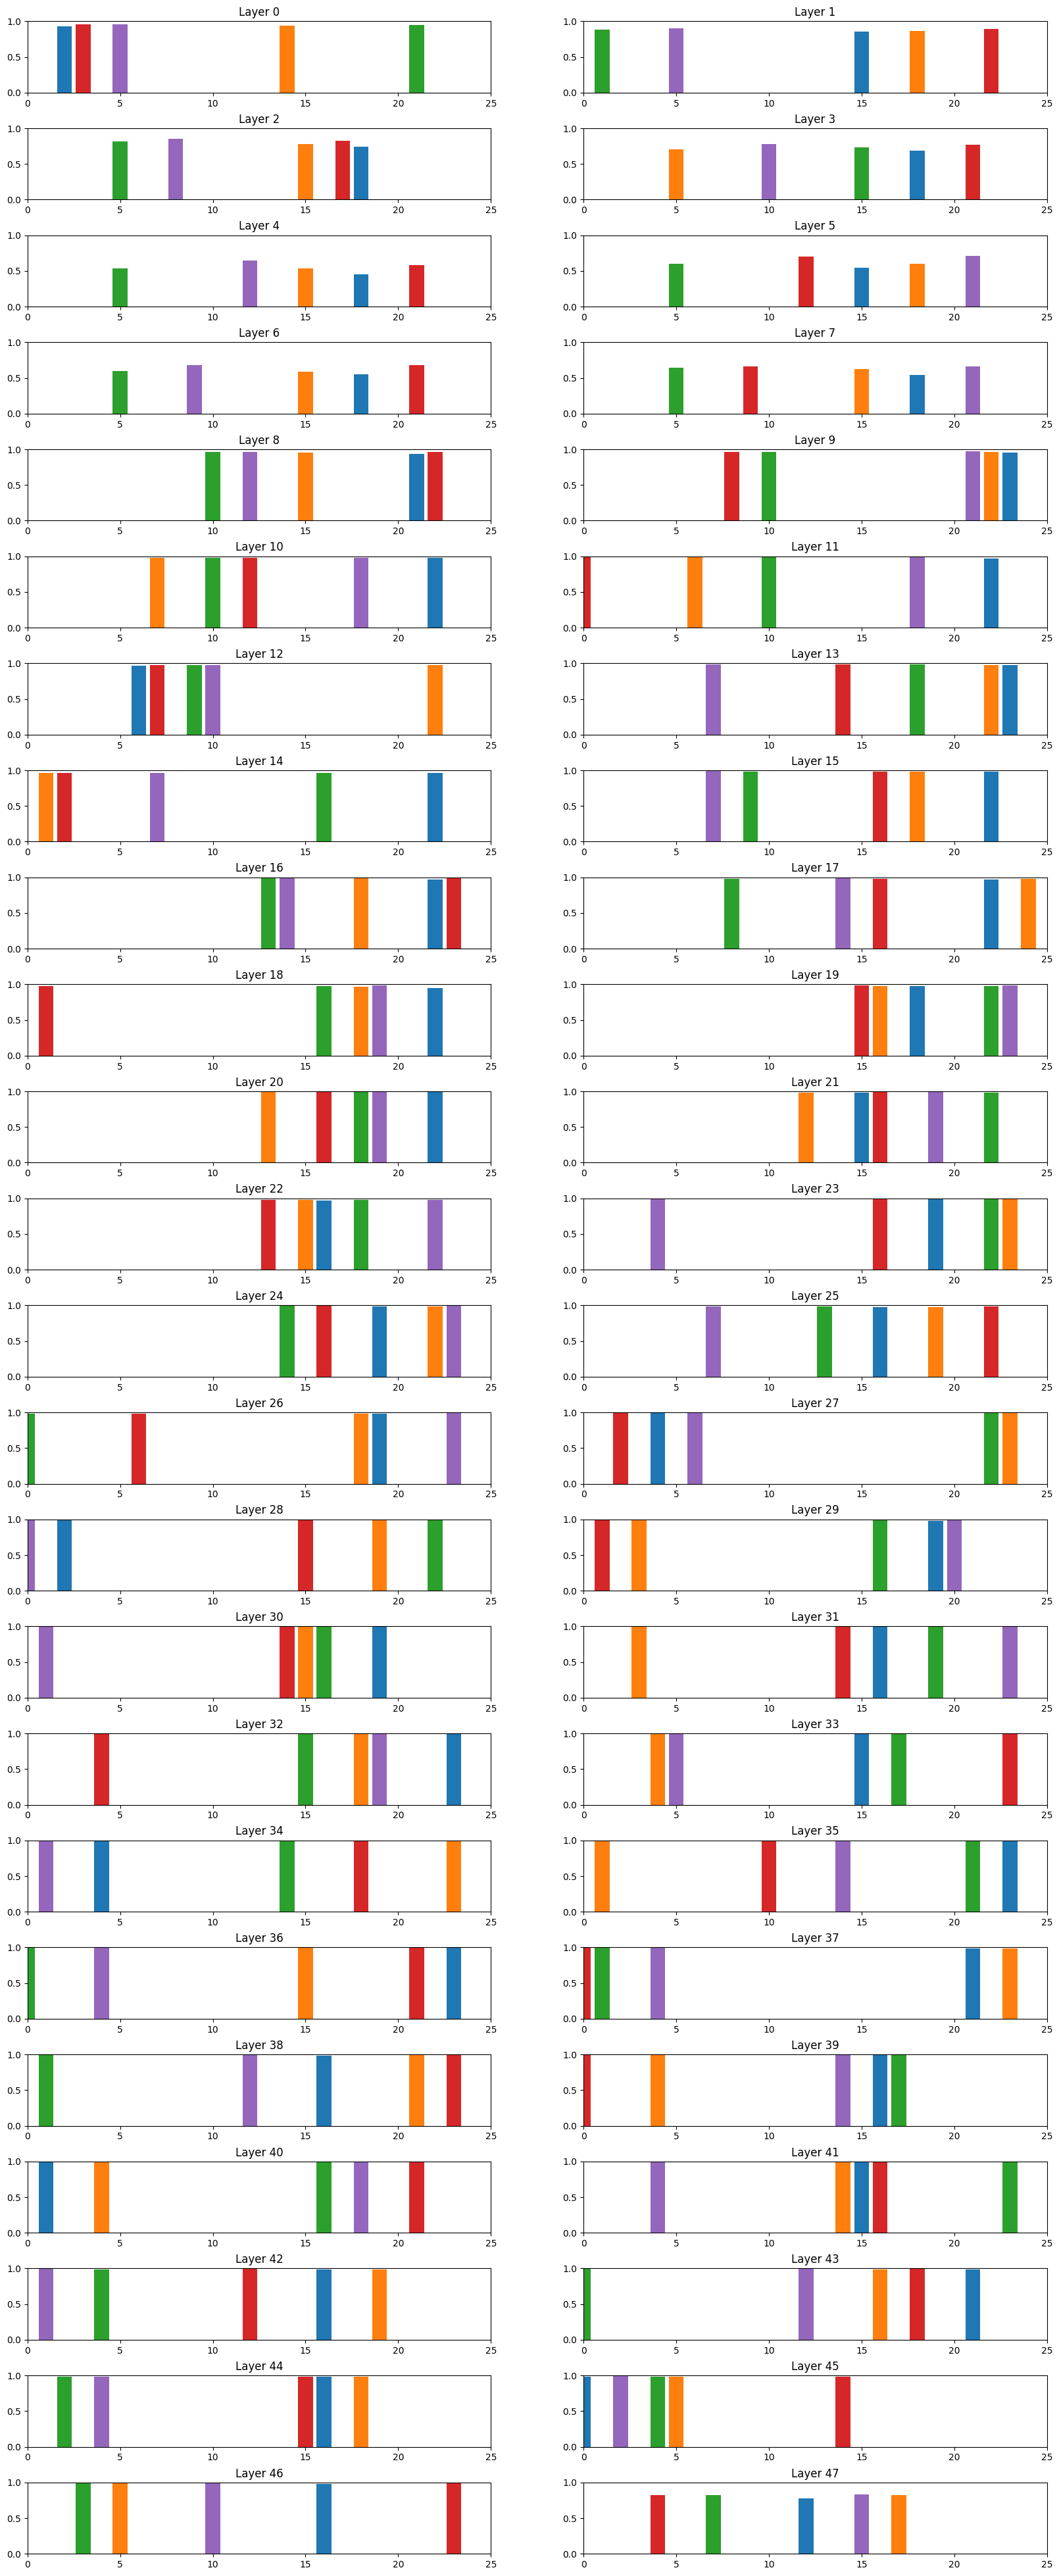

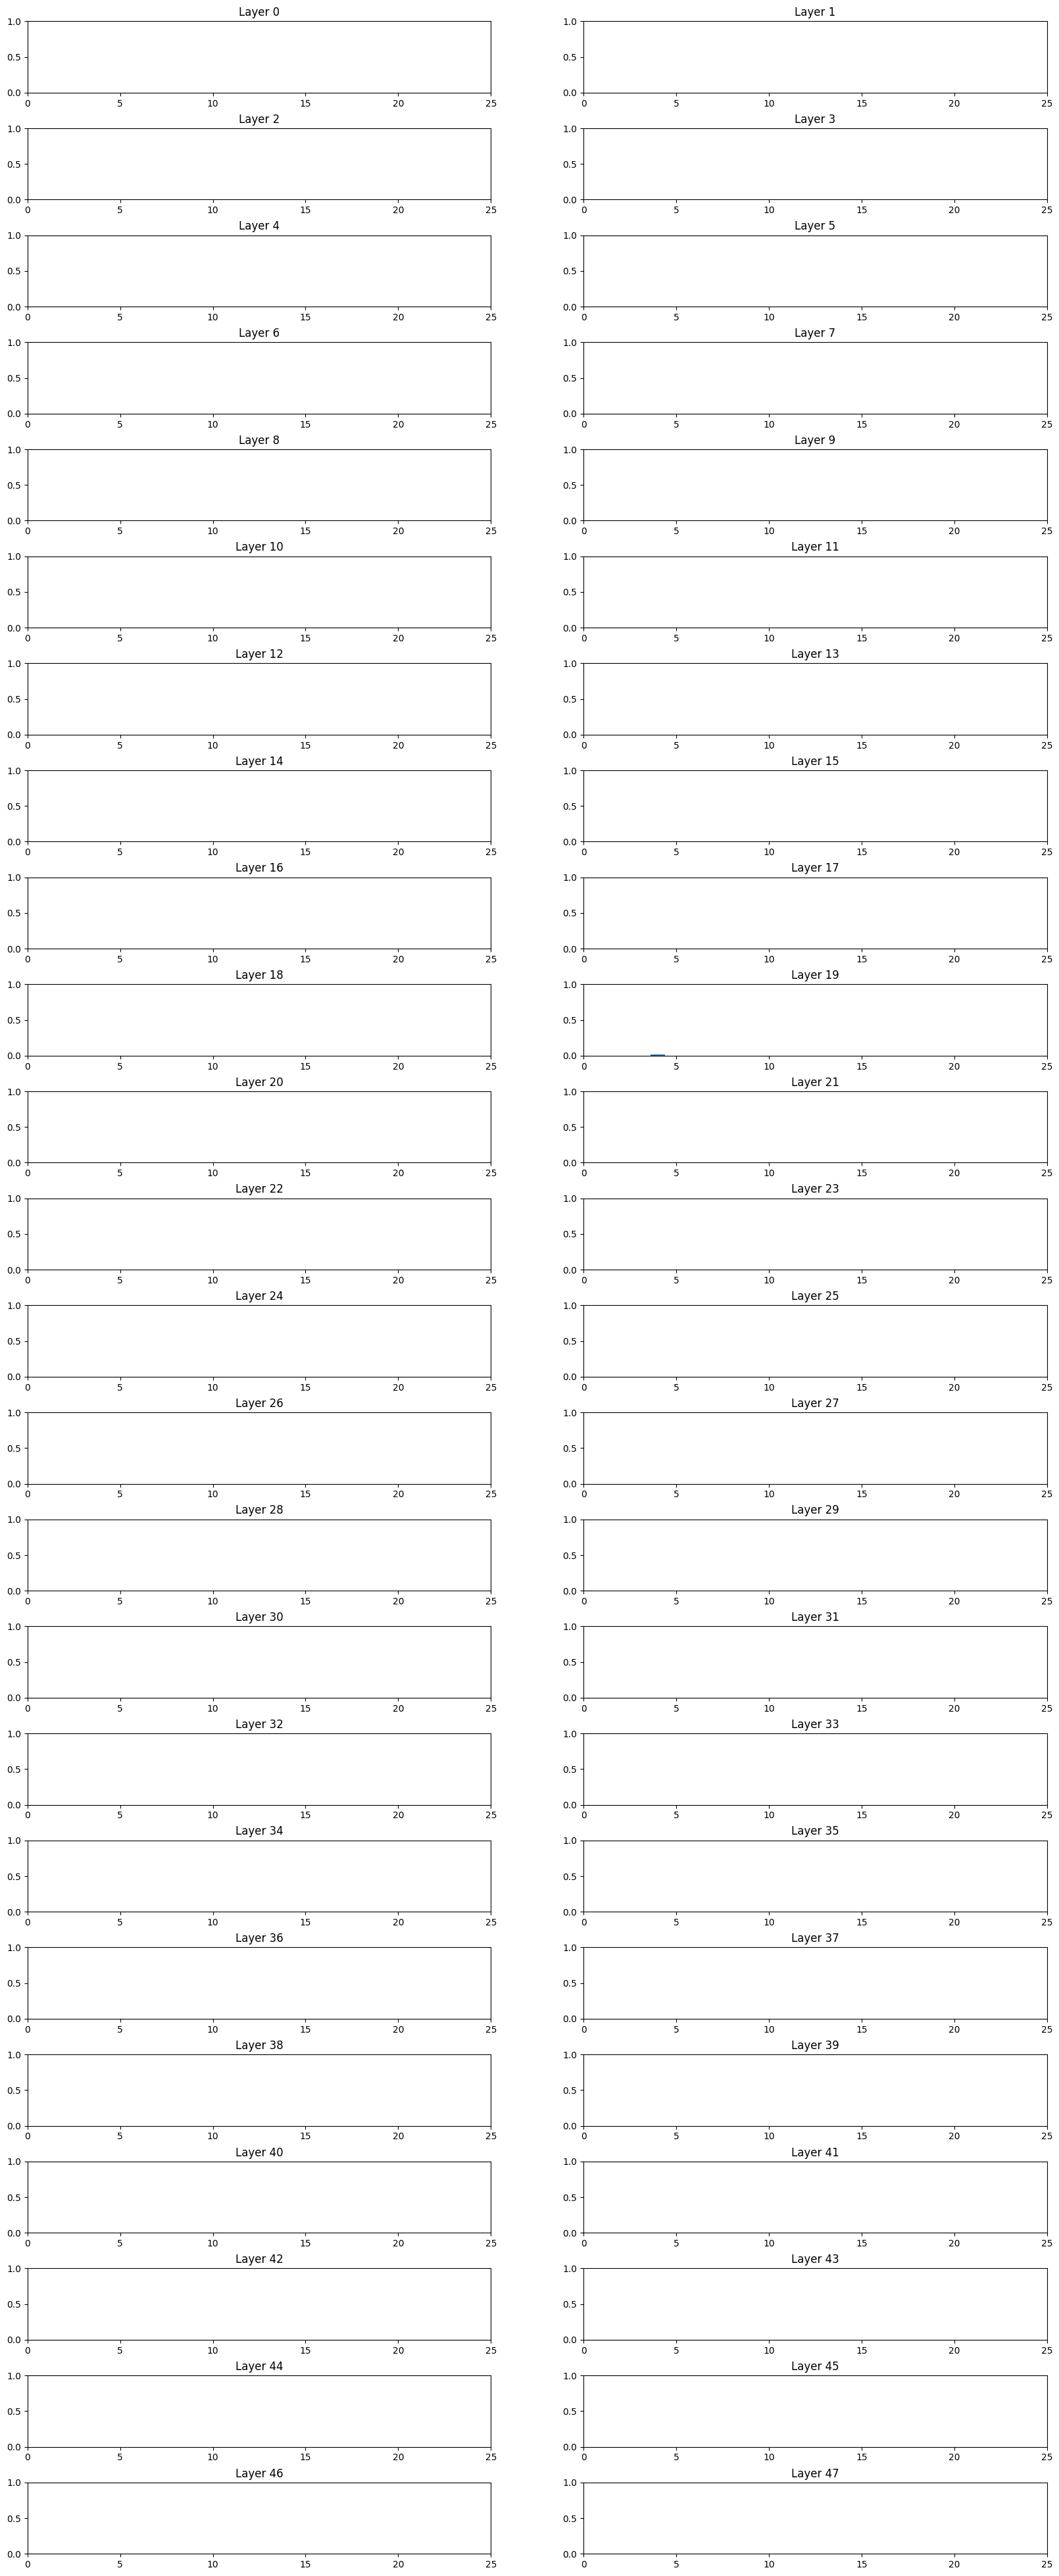

In [157]:
compare_all_patterns(all_top_activations, all_bottom_activations, model_config)

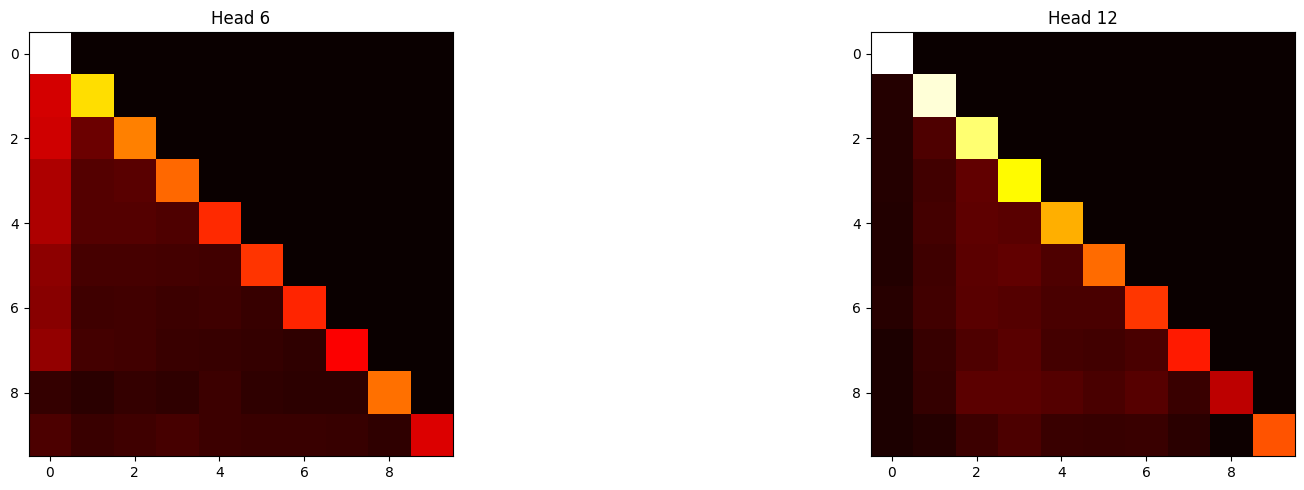

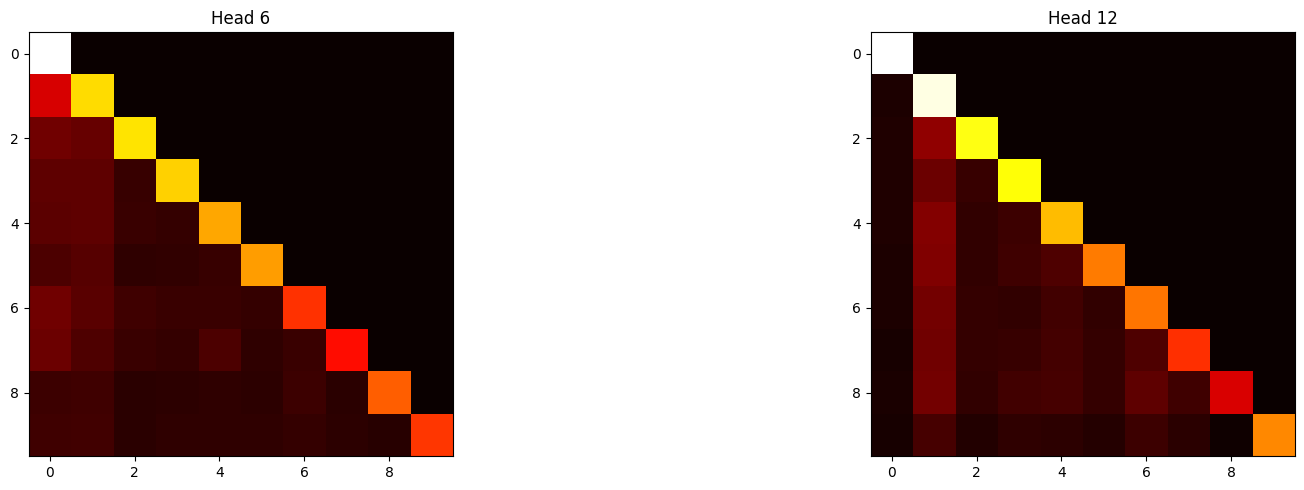

In [7]:
display_patterns(fast_activations, layer=4, heads=[6, 12])
display_patterns(slow_activations, layer=4, heads=[6, 12])

# Activation Patching

In [138]:
def patch(all_new_activations, model_name):
    if model_name == "gpt2":
        model_name = "gpt2-small"
    model = HookedTransformer.from_pretrained(model_name, device=device)

    if all_new_activations == "random":
        new_activations = torch.rand((model_config.n_layer, model_config.n_head, sentence_len, sentence_len))
    else:
        new_activations = torch.zeros((model_config.n_layer, model_config.n_head, sentence_len, sentence_len))
        for layer in range(model_config.n_layer):
            for head in range(model_config.n_head):
                new_activations[layer, head] = torch.mean(all_new_activations["pattern", layer, "attn"].detach().cpu(), axis=0)[head]

    layer = 2
    head = 9
    location = f"blocks.{layer}.attn.hook_pattern"
        
    def replace_activations(input, hook):
        input[:, head, :, :] = new_activations[layer, head].to(device)
        return input

    cache = model.add_caching_hooks()


    model.run_with_hooks(
        top_sentences, 
        return_type=None,
        fwd_hooks=[(
            location,
            replace_activations
        )]
    )

    # logits = logits.detach().cpu().numpy()

    # #get sentences from logits
    # new_sentences = []
    # for i in range(logits.shape[0]):
    #     new_sentences.append(np.argmax(logits[i], axis=1))

    # model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
    # activations = compute_model_activations(model, new_sentences, device)

    # new_curvatures = compute_model_curvature(activations)
    new_activations = torch.zeros((model_config.n_layer, 50, sentence_len, embedding_dim))
    for layer in range(model_config.n_layer):
        new_activations[layer] = cache[f"blocks.{layer}.hook_resid_post"]

    #all_layers shape: (samples, layers, tokens, hidden_size)
    new_activations = new_activations.reshape(-1, model_config.n_layer, sentence_len, embedding_dim)
    new_curvatures = compute_model_curvature(new_activations)

    return new_curvatures

In [139]:
straighter_curvatures = patch(all_bottom_activations, "gpt2")
random_curvatures = patch("random", "gpt2")

Loaded pretrained model gpt2-small into HookedTransformer


0it [00:00, ?it/s]/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
600it [00:00, 1269.71it/s]


Loaded pretrained model gpt2-small into HookedTransformer


600it [00:00, 1275.31it/s]


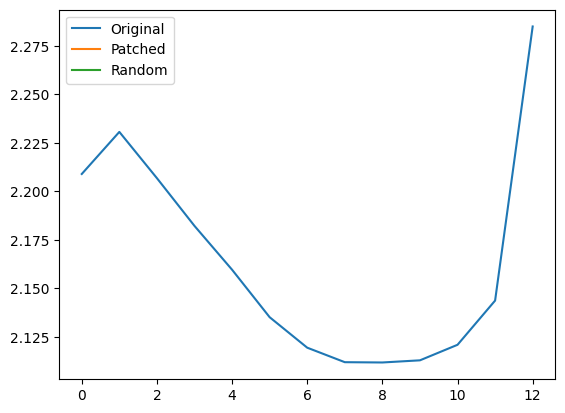

In [140]:
top_curvatures = curvatures["curve"][:, top_50]
plt.plot(np.mean(top_curvatures, axis=1), label="Original")
plt.plot(np.mean(straighter_curvatures["curve"], axis=1), label="Patched")
plt.plot(np.mean(random_curvatures["curve"], axis=1), label="Random")
plt.legend()
plt.show()

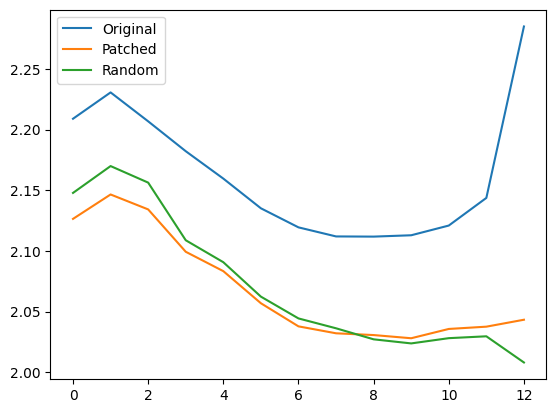

In [104]:
top_curvatures = curvatures["curve"][:, top_50]
plt.plot(np.mean(top_curvatures, axis=1), label="Original")
plt.plot(np.mean(straighter_curvatures["curve"], axis=1), label="Patched")
plt.plot(np.mean(random_curvatures["curve"], axis=1), label="Random")
plt.legend()
plt.show()

# Getting Curvatures

In [153]:
data_dir = "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
with open(data_dir, 'rb') as f:
    data = pickle.load(f)

clean_sentences = []
for i, raw_sentence in enumerate(data):
    sentence = tokenizer.encode(raw_sentence)
    if len(sentence) < 10:
        pass
    sentence = sentence[:10]
    clean_sentences.append(sentence)

# data_path = '/om/weka/evlab/ehoseini/MyData/miniBERTa_v2/'
# data_size = "10M"
# data = load_from_disk(
#     os.path.join(data_path, f'miniBERTa-{data_size}-crunched',
#                     f'valid_context_len_{512}'))

# sentences = data['input_ids'][:5000]
# clean_sentences = []

# for i in range(len(sentences)):
#     sentence = sentences[i][:10]
#     x = [j for j in sentence if j == tokenizer.eos_token_id]
#     if len(x) > 2:
#         pass
#     clean_sentences.append(sentence)

model_name = "gpt2-xl"

model = GPT2LMHeadModel.from_pretrained(model_name)
model.to(device)

activations = compute_model_activations(model, clean_sentences, device)
curvatures = compute_model_curvature(activations)

with open(f"{path}/data/{model_name}_ud_activations.pkl", "wb") as f:
    pickle.dump(activations, f)

with open(f"{path}/data/{model_name}_ud_curvatures.pkl", "wb") as f:
    pickle.dump(curvatures, f)

with open(f"{path}/data/{model_name}_ud_clean_sentences.pkl", "wb") as f:
    pickle.dump(clean_sentences, f)

100%|██████████| 5815/5815 [02:50<00:00, 34.08it/s]
5815it [01:14, 77.92it/s]


In [33]:
with open(f"{path}/data/{model_name}_onminibert_activations.pkl", "wb") as f:
    pickle.dump(activations, f)

with open(f"{path}/data/{model_name}_onminibert_curvatures.pkl", "wb") as f:
    pickle.dump(curvatures, f)

In [24]:
data_path = '/om/weka/evlab/ehoseini/MyData/miniBERTa_v2/'
data_size = "10M"
data = load_from_disk(
    os.path.join(data_path, f'miniBERTa-{data_size}-crunched',
                    f'valid_context_len_{512}'))

sentences = data['input_ids'][:1000]
clean_sentences = []

for i in range(len(sentences)):
    sentence = sentences[i][:20]
    x = [j for j in sentence if j == tokenizer.eos_token_id]
    if len(x) > 2:
        pass
    clean_sentences.append(sentence)

model = GPT2LMHeadModel.from_pretrained("gpt2-xl")
model.to(device)
activations = compute_model_activations(model, clean_sentences, device)
curvatures = compute_model_curvature(activations)


100%|██████████| 1000/1000 [00:28<00:00, 34.54it/s]
1000it [00:20, 48.23it/s]


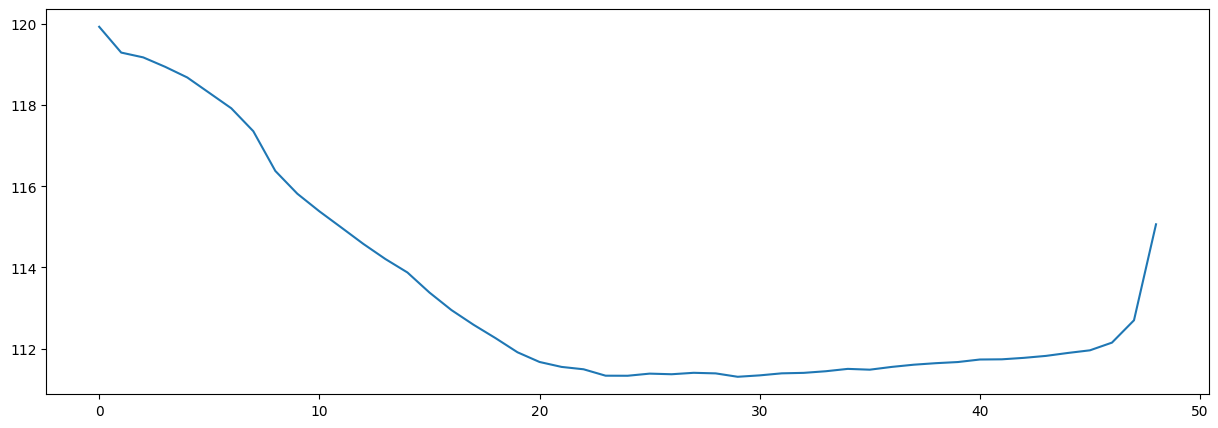

In [26]:
curve = np.mean(curvatures["curve"], axis=1) / np.pi * 180
#make the frame of the plot longer horizontally
plt.figure(figsize=(15, 5))
plt.plot(curve)
plt.show()

In [ ]:
np.mean(np.std(curvatures["all_layer_curve_all"], axis=0)[:, i-1:i], axis = -1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


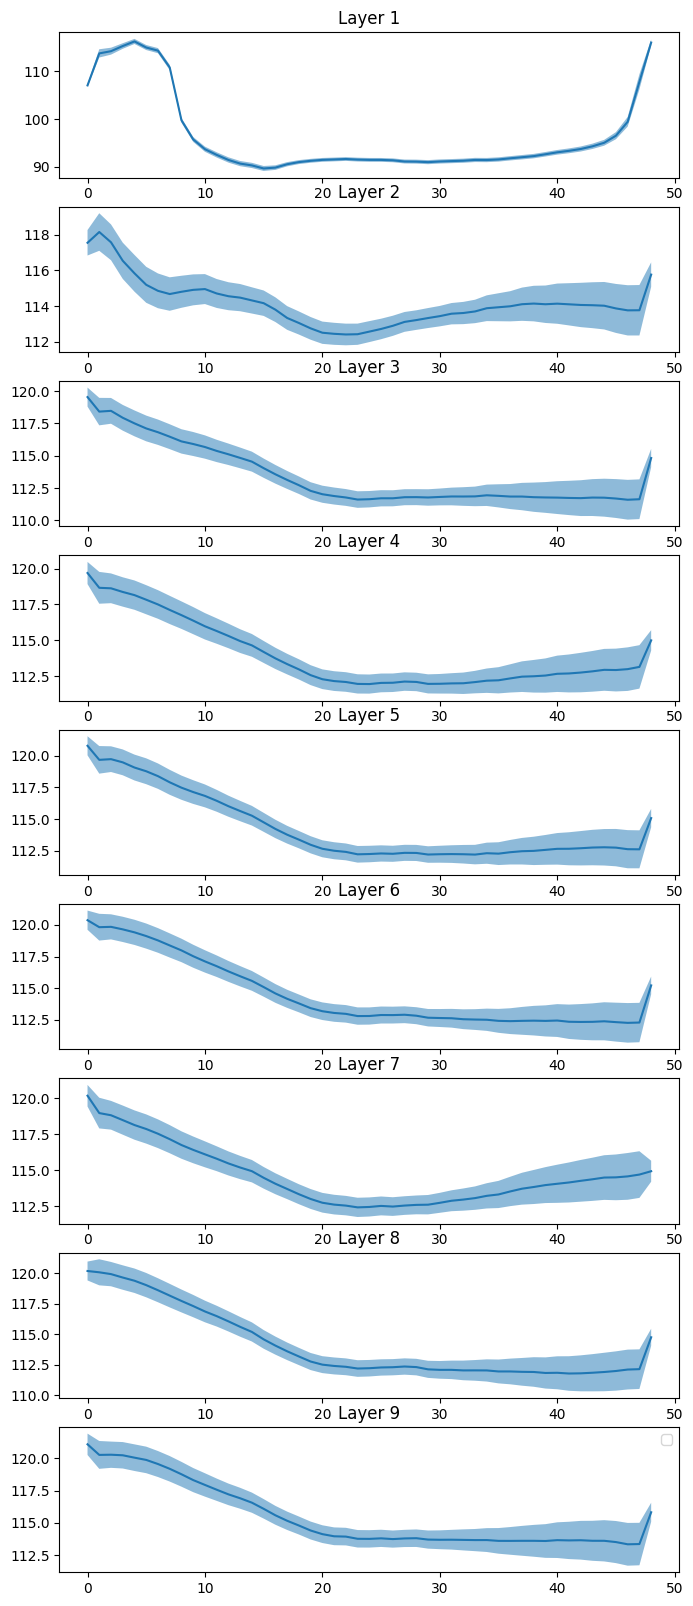

In [40]:
fig, axs = plt.subplots(7, 1, figsize=(8, 20))
for i in range(1, 8):
    curve = np.mean(np.mean(curvatures["all_layer_curve_all"], axis=0)[:, i-1:i], axis = -1) / np.pi * 180
    curve_std = np.mean(np.std(curvatures["all_layer_curve_all"], axis=0)[:, i-1:i], axis = -1) / np.pi * 180
    curve_conf = curve_std * 1.96 / np.sqrt(1000)
    axs[i-1].plot(curve)
    axs[i-1].fill_between(np.arange(49), curve - curve_conf, curve + curve_conf, alpha=0.5)
    axs[i-1].set_title(f"Curve {i}")

plt.legend()
plt.show()